# Backpropagation

This is meant to deepen the understanding of backpropagation and (stochastic) gradient descent in NN.

## Softmax Linear Classifier

Initially a linear classifier, then move to 2-layer NN.

In [62]:
import numpy as np
from matplotlib import pyplot as plt

Normally we would want to preprocess the dataset so that each feature has zero mean and unit standard deviation, but in this case the features are already in a nice range from -1 to 1, so we skip this step.

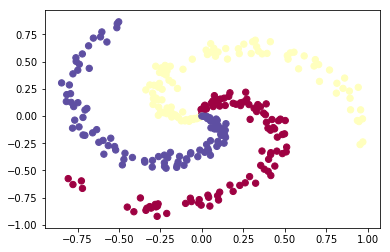

In [75]:
# Generate a spiral dataset
N = 100  # number of points per class
D = 2  # dimensionality
K = 3  # number of classes
X = np.zeros((N * K, D))  # data matrix (each row = single example)
y = np.zeros(N * K, dtype='uint8')  # class labels
for j in range(K):
    ix = range(N * j, N * (j + 1))
    r = np.linspace(0.0, 1, N)  # radius
    t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2  # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [76]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))

In [77]:
scores = np.dot(X, W) + b
scores

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -7.81081207e-05,  -4.05397930e-06,   1.26890690e-04],
       [ -1.43432414e-04,  -1.61111533e-05,   2.28869536e-04],
       [ -1.91544072e-04,  -3.35339727e-05,   2.99892906e-04],
       [ -2.61452634e-04,  -4.26355684e-05,   4.10846064e-04],
       [ -3.62826642e-04,  -3.81799830e-05,   5.80179486e-04],
       [ -4.50898169e-04,  -3.71717214e-05,   7.25923933e-04],
       [ -3.68188607e-04,  -9.99319487e-05,   5.59497563e-04],
       [ -4.61830955e-04,  -1.04032655e-04,   7.11987569e-04],
       [ -5.93983200e-04,  -9.38855793e-05,   9.34806933e-04],
       [ -6.46768093e-04,  -1.08979040e-04,   1.01465194e-03],
       [ -3.75482714e-04,  -1.93036218e-04,   5.27011819e-04],
       [ -4.94106724e-04,  -1.98013666e-04,   7.20286580e-04],
       [ -6.42521535e-04,  -1.94604964e-04,   9.66707048e-04],
       [ -2.66293180e-04,  -2.67999546e-04,   3.11075500e-04],
       [ -7.43807418e-04,  -2.24034866e-04,   1.1196932

Compute the Loss for the Softmax classifier:

$L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right)$

Softmax classifier interprets every element of f as holding the (unnormalized) log probabilities of the three classes. We exponentiate these to get (unnormalized) probabilities and then normalize them to get probabilities.

As $-\log(x)$ coverges towards infinity for x=0 and 0 for x=1 the loss is high if the probability inside the parentheses is small and low if it is large.

The *full Softmax classifier loss* is then defined as the average *cross-entropy loss* over all training examples:

$ L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss} \\\\ $


In [78]:
scores.shape

(300, 3)

In [79]:
scores[:4]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -7.81081207e-05,  -4.05397930e-06,   1.26890690e-04],
       [ -1.43432414e-04,  -1.61111533e-05,   2.28869536e-04],
       [ -1.91544072e-04,  -3.35339727e-05,   2.99892906e-04]])

In [80]:
# compute loss of the scores
num_examples = X.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [81]:
# each row contains the class probabilities
probs[:4]

array([[ 0.33333333,  0.33333333,  0.33333333],
       [ 0.33330233,  0.33332701,  0.33337066],
       [ 0.33327782,  0.33332026,  0.33340192],
       [ 0.33326117,  0.33331384,  0.33342499]])

In [82]:
# get log of probabilities of the actual classes
# the array indexing/querying here works as follows np.array([...])[[ROW_INDICES], [COL_INDICES]]
correct_probs = probs[range(num_examples),y]
corect_logprobs = -np.log(correct_probs)

In [83]:
reg = 0.5 # regularization strength
# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(corect_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

Computing the analytic gradient with backpropagation.

Loss for one example is:

$ p_k = \frac{e^{f_k}}{ \sum_j e^{f_j} } \hspace{1in} L_i =-\log\left(p_{y_i}\right) $

We now want to understand how the computed scores inside $f$ should change to decrease the loss $L_i$. In other words derive the gradient $ \partial L_i / \partial f_k $ .

Chain rule:

$ \frac{\partial L_i}{\partial f_k} = \frac{\partial L_i}{\partial p} \frac{\partial p}{\partial f_k}  $

$ \frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k) $

That means for probabilities of `p = [0.2, 0.3, 0.5]` and correct class is middle one, the gradient on the scores would be `df = [0.2, -0.7, 0.5]`. 

In [90]:
# probs are probabilities of all classes (as rows)
dscores = np.copy(probs)
dscores[range(num_examples),y] -= 1 # using the previously calculated formulat (p_k - 1)
# avg gradients on scores
dscores /= num_examples

Note that the regularization gradient has the very simple form `reg*W` since we used the constant 0.5 for its loss contribution (i.e. $ \frac{d}{dw} ( \frac{1}{2} \lambda w^2) = \lambda w $)

In [91]:
# backpropagate into W and b
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # don't forget the regularization gradient

In [93]:
step_size = 1e-0
# Perform a parameter update in the negative gradient direction to decrease loss!
W += -step_size * dW
b += -step_size * db

In [94]:
# putting it all together
# initialize parameters randomly
W = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3  # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b

    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs) / num_examples
    reg_loss = 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print("iteration %d: loss %f" % (i, loss))

    # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    dW += reg * W  # regularization gradient

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.097798
iteration 10: loss 0.900820
iteration 20: loss 0.827351
iteration 30: loss 0.793641
iteration 40: loss 0.775893
iteration 50: loss 0.765675
iteration 60: loss 0.759424
iteration 70: loss 0.755431
iteration 80: loss 0.752798
iteration 90: loss 0.751018
iteration 100: loss 0.749791
iteration 110: loss 0.748934
iteration 120: loss 0.748327
iteration 130: loss 0.747892
iteration 140: loss 0.747579
iteration 150: loss 0.747352
iteration 160: loss 0.747186
iteration 170: loss 0.747064
iteration 180: loss 0.746974
iteration 190: loss 0.746908


In [95]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.54
